In [36]:
%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

from quickda.explore_data import *
from quickda.clean_data import *
from quickda.explore_numeric import *
from quickda.explore_categoric import *
from quickda.explore_numeric_categoric import *
from quickda.explore_time_series import *

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

sns.set_style('whitegrid')
sns.set_context('notebook')

import warnings
warnings.filterwarnings('ignore')


In [37]:
def percentual_outlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)
    num_outliers =  np.sum((data < minimum) | (data > maximum))
    num_total = data.count()
    return (num_outliers/num_total)*100

def calculate_wcss(data, num):
        wcss = []
        for n in range(2, num):
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(X=data)
            wcss.append(kmeans.inertia_)
    
        return wcss
    
def calculate_silhouete(data, num):
        silhouete_avg = []
        for n in range(2, num):
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(X=data)
            cluster_labels = kmeans.labels_
            silhouete_avg.append(silhouette_score(data, cluster_labels))
    
        return silhouete_avg

def spider_plot(data, cluster):
    means = np.c_[data.groupby('kmeans').mean().to_numpy(), np.zeros(5)]
    names = np.r_[data.columns[0:-1], ['']]
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(names))
    categories = np.arange(0, len(means))
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(projection="polar")
    #for i in range(len(means)):
    ax.plot(label_loc, means[cluster], label=f'class {categories[cluster]}')
    ax.set_title(f'Cluster {cluster}', size=20)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=names)
    plt.show()

## Carregando os Dados

In [38]:
df = pd.read_csv("./dados_cluster.csv")

In [39]:
explore(df)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
anoFundacao,float64,4733,0,0.000,64,1000.0,2000.0,2008.0,2014.0,2020.0,2005.399324,2008.0,18.804873,-32.704409
ativoCirculante,float64,4733,0,0.000,1794,-17.0,887585.0,3996630.0,16351166.0,29038320000.0,44510281.217198,3996630.0,467453419.135309,52.136866
capitalSocial,float64,4733,0,0.000,296,0.0,100000.0,200000.0,1000000.0,4100000000.0,11937800.018804,200000.0,99492765.184206,22.066796
cnpjSemTraco,object,4733,0,0.000,1523,AADG56617962174727,-,-,-,ZZVU59020803434073,-,-,-,-
custos,float64,4731,2,0.000,1690,-346633805.0,90726.5,2649521.0,15824595.5,4393536000.0,48462291.808497,2649521.0,270477012.207705,11.864482
dashboardCorrelacao,float64,4733,0,0.000,502,-0.99999,0.0,0.0,0.0,0.99999,0.031505,0.0,0.530149,-0.035707
dataAprovadoEmComite,object,368,4365,0.922,368,-,-,-,-,-,-,-,-,-
dataAprovadoNivelAnalista,object,4020,713,0.151,4020,-,-,-,-,-,-,-,-,-
definicaoRisco,object,4733,0,0.000,4,De 0 a 10 % - Muito Baixo,-,-,-,De 51 a 80 % - Alto,-,-,-,-
diferencaPercentualRisco,float64,4733,0,0.000,73,0.339286,0.696429,0.773585,0.857143,1.0,0.766956,0.773585,0.117685,-0.49286


## Retirando cnpjs duplicados

In [40]:
df.drop_duplicates(subset='cnpjSemTraco', keep='last', inplace=True)

## Retirando as colunas que não iremos usar na análise de clusters

In [41]:
df.drop(['valorAprovado', 'dataAprovadoEmComite', 'dataAprovadoNivelAnalista', 'percentualProtestos', 'numero_solicitacao', 
         'razaoSocial', 'nomeFantasia', 'anoFundacao', 'status', 'definicaoRisco', 'diferencaPercentualRisco', 'dashboardCorrelacao', 
         'periodoBalanco', 'primeiraCompra', 'intervaloFundacao', 'periodoDemonstrativoEmMeses', 'cnpjSemTraco'], axis=1, inplace=True)

In [42]:
explore(df)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
maiorAtraso,int64,1523,0,0.0,153,0,0.000,5.000,2.000000e+01,977,2.312500e+01,5.000,6.099000e+01,7.657
margemBrutaAcumulada,float64,1523,0,0.0,1200,0.0,0.220,0.387,4.950000e-01,1.0,3.400000e-01,0.387,2.110000e-01,-0.448
prazoMedioRecebimentoVendas,int64,1523,0,0.0,149,0,0.000,0.000,2.100000e+01,1605,2.012000e+01,0.000,6.307400e+01,12.886
titulosEmAberto,float64,1523,0,0.0,563,0.0,0.000,0.000,9.940000e+03,2836656.0,4.092816e+04,0.000,1.765397e+05,8.188
valorSolicitado,float64,1523,0,0.0,159,100.0,30000.000,60000.000,1.635000e+05,600000000.0,6.168863e+05,60000.000,1.537781e+07,38.957
percentualRisco,float64,1523,0,0.0,63,0.0,0.143,0.214,3.040000e-01,0.660714,2.220000e-01,0.214,1.190000e-01,0.635
ativoCirculante,float64,1523,0,0.0,1178,0.0,298293.000,2451304.000,1.134704e+07,29038320000.0,5.391843e+07,2451304.000,7.876672e+08,33.697
passivoCirculante,float64,1523,0,0.0,1168,-1134941.0,44519.500,779307.000,4.808169e+06,27503820000.0,4.559232e+07,779307.000,7.883526e+08,30.801
totalAtivo,float64,1523,0,0.0,1180,0.0,364756.000,2846875.000,1.291962e+07,54823500000.0,9.602702e+07,2846875.000,1.512397e+09,32.449
totalPatrimonioLiquido,float64,1523,0,0.0,1166,-186719734.0,49100.500,1101916.000,5.735235e+06,12923280000.0,3.247566e+07,1101916.000,4.124506e+08,26.956


In [43]:
fig = px.box(data_frame = df, height=600, title='Banco de Dados Original')
fig.show()

ValueError: Plotly Express cannot process wide-form data with columns of different type.

## Como podemos ver no Boxplot acima temos diversos valores outliers. Como iremos fazer uma análise de clusterização que leva em conta as distancias entre os dados estes outliers podem atrapalhar o resultado final, pois no gráfico nem é possível ver o boxplot corretamente.<BR>
## Para visualizarmos melhor vamos calcular o percentual de dados acima e abaixo dos limites inferior e superior, respctivamente, do gráfico boxplot.

In [ ]:
for coluna in df.columns:
    data = df[coluna]
    perc = str(round(percentual_outlier(data), 2))
    print(f'Outliers na coluna {coluna} : {perc}%')

In [44]:
mmsc = MinMaxScaler().fit(df)
df_mmsc = pd.DataFrame(mmsc.transform(df), columns=df.columns)
explore(df_mmsc)

,dtypes,count,null_sum,null_pct,nunique,min,25%,50%,75%,max,mean,median,std,skew
maiorAtraso,float64,1523,0,0.0,153,0.0,0.000,0.005,0.020,1.0,0.024,0.005,0.062,7.657
margemBrutaAcumulada,float64,1523,0,0.0,1200,0.0,0.220,0.387,0.495,1.0,0.340,0.387,0.211,-0.448
prazoMedioRecebimentoVendas,float64,1523,0,0.0,149,0.0,0.000,0.000,0.013,1.0,0.013,0.000,0.039,12.886
titulosEmAberto,float64,1523,0,0.0,563,0.0,0.000,0.000,0.004,1.0,0.014,0.000,0.062,8.188
valorSolicitado,float64,1523,0,0.0,159,0.0,0.000,0.000,0.000,1.0,0.001,0.000,0.026,38.957
percentualRisco,float64,1523,0,0.0,63,0.0,0.216,0.324,0.459,1.0,0.337,0.324,0.180,0.635
ativoCirculante,float64,1523,0,0.0,1178,0.0,0.000,0.000,0.000,1.0,0.002,0.000,0.027,33.697
passivoCirculante,float64,1523,0,0.0,1168,0.0,0.000,0.000,0.000,1.0,0.002,0.000,0.029,30.801
totalAtivo,float64,1523,0,0.0,1180,0.0,0.000,0.000,0.000,1.0,0.002,0.000,0.028,32.449
totalPatrimonioLiquido,float64,1523,0,0.0,1166,0.0,0.014,0.014,0.015,1.0,0.017,0.014,0.031,26.956


# PCA

In [45]:
pca = PCA(n_components=0.95, svd_solver='full', random_state=42)
pca.fit(df_mmsc)
PCA_labels = ['PC'+str(x) for x in range(1,len(pca.components_)+1)]
df_pca = pd.DataFrame(pca.transform(df_mmsc), columns=PCA_labels)
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6
0,0.556825,0.920021,-0.161342,-0.026589,0.013239,-0.025657
1,0.723119,-0.128326,-0.023003,-0.033576,-0.045893,0.014520
2,0.567168,0.923014,-0.149472,0.028734,0.011284,-0.023482
3,0.577546,0.926053,-0.137633,0.083739,0.009367,-0.020763
4,0.723067,-0.126966,-0.023238,-0.033473,-0.047746,0.014262
...,...,...,...,...,...,...
1518,-0.244256,-0.348016,-0.058501,0.123137,0.076642,0.019149
1519,-0.306788,-0.142720,-0.123528,-0.032639,0.003608,-0.012059
1520,0.723101,-0.159037,-0.022659,-0.053115,0.022426,0.011605
1521,-0.282902,-0.321183,-0.093104,-0.035862,-0.008563,0.033805


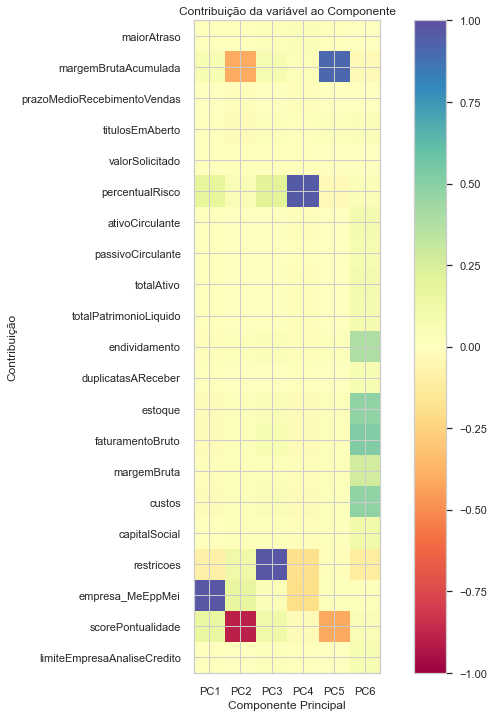

In [46]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(pca.components_.T, cmap="Spectral", vmin=-1, vmax=1)
plt.yticks(range(len(df_mmsc.columns)), df_mmsc.columns)
plt.xticks(range(len(df_pca.columns)), df_pca.columns)
plt.xlabel("Componente Principal")
plt.ylabel("Contribuição")
plt.title("Contribuição da variável ao Componente")
plt.colorbar()

## Definindo valores para KMeans

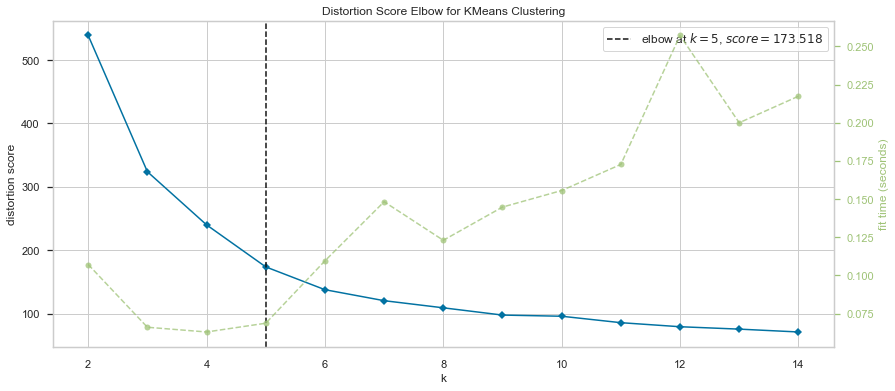

In [47]:
fig = plt.figure(figsize=(14,6))

model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, k=(2,15))

distortion_visualizer.fit(df_mmsc)       
distortion_visualizer.show()
plt.show()

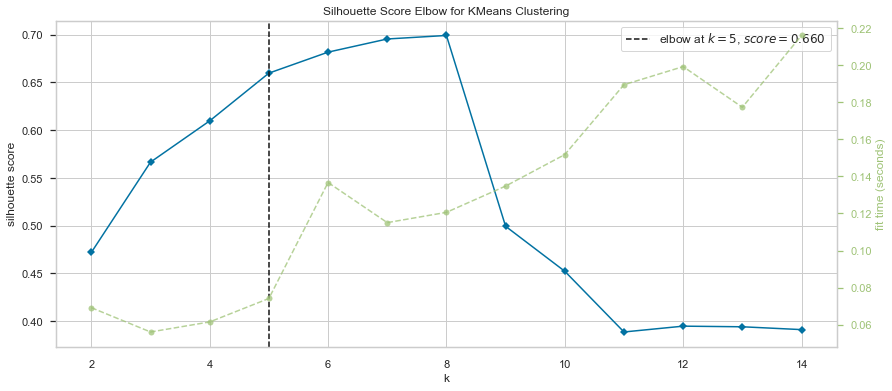

In [48]:
fig = plt.figure(figsize=(14,6))

model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, metric='silhouette',k=(2,15))

distortion_visualizer.fit(df_mmsc)       
distortion_visualizer.show()
plt.show()

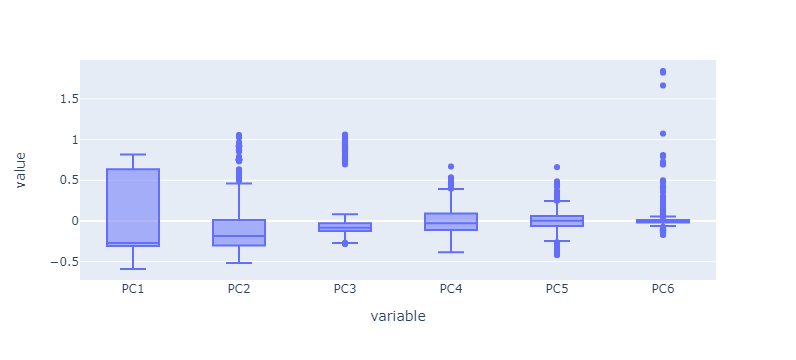

In [49]:
fig = px.box(df_pca)
fig.show()

## Gerando Clusters

In [50]:
km = KMeans(n_clusters=5, n_init=100)
km_labels = km.fit_predict(df_pca)

In [51]:
df_mmsc['kmeans'] = km_labels
df_pca['kmeans'] = km_labels
df['kmeans'] = km_labels

In [52]:
df.groupby('kmeans').ativoCirculante.count()

kmeans
0    383
1    728
2    122
3    190
4    100
Name: ativoCirculante, dtype: int64

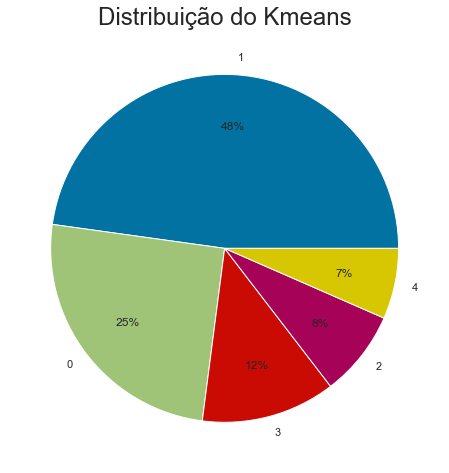

In [53]:
fig = plt.figure(figsize=(8,8))
df_pca.kmeans.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)
plt.title('Distribuição do Kmeans', size=24)
plt.ylabel("")
plt.show()

In [54]:
with pd.ExcelWriter("df_excel.xlsx") as writer:
    df.to_excel(writer)

# Avaliação do Modelo

Vamos usar duas métricas para avaliar o modelo, e depois analisar algugns gráficos

The Davis-Bouldin Index is the average similarity between each cluster and the closest cluster. Scores range from 0 and up. 0 indicates better clustering.
The Silhouette Coefficient is a value between -1 and 1. The higher the score, the better. 1 indicates tight clusters, and 0 means overlapping clusters.

In [55]:
print(f'Davies-Bouldin index = {davies_bouldin_score(df_pca, km_labels)}')
print(f'Silhouette Score = {silhouette_score(df_pca, km_labels)}')

Davies-Bouldin index = 0.44880106628138083
Silhouette Score = 0.7765772810679572


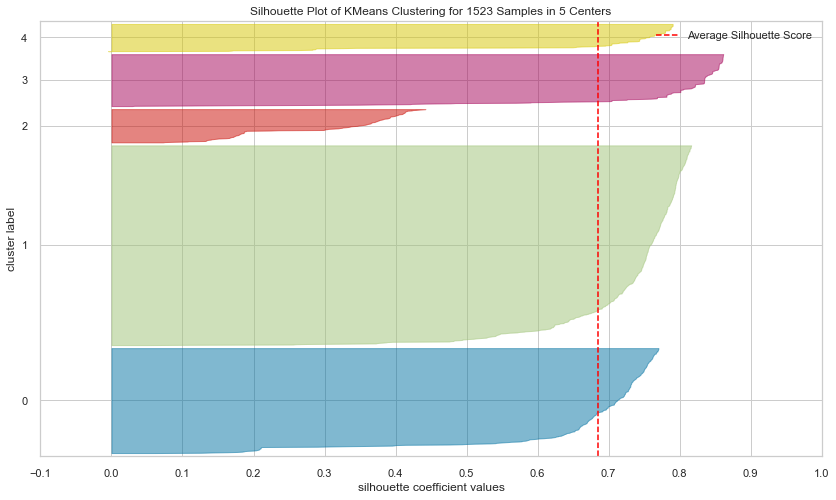

In [56]:
fig = plt.figure(figsize=(14,8))

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(df_pca.drop(['kmeans'],axis=1))
visualizer.show()
plt.show()

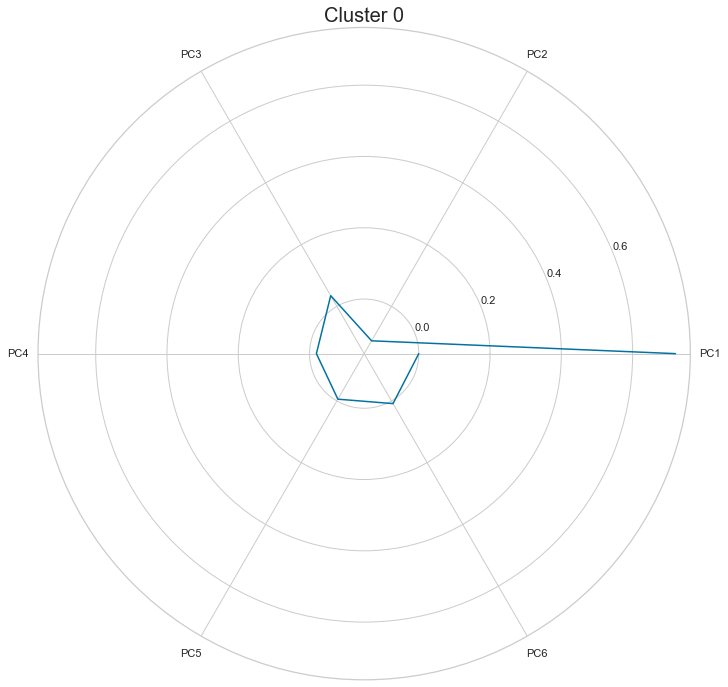

In [57]:
spider_plot(df_pca, 0)

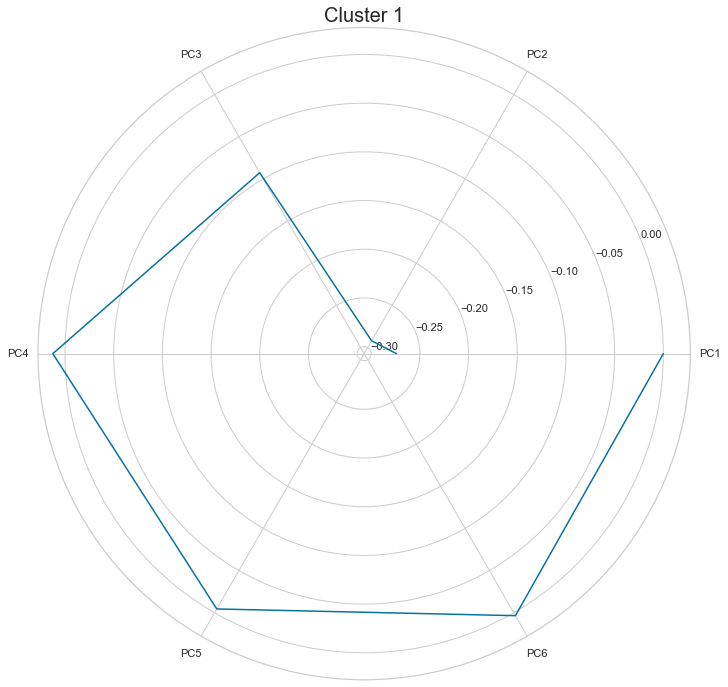

In [58]:
spider_plot(df_pca, 1)

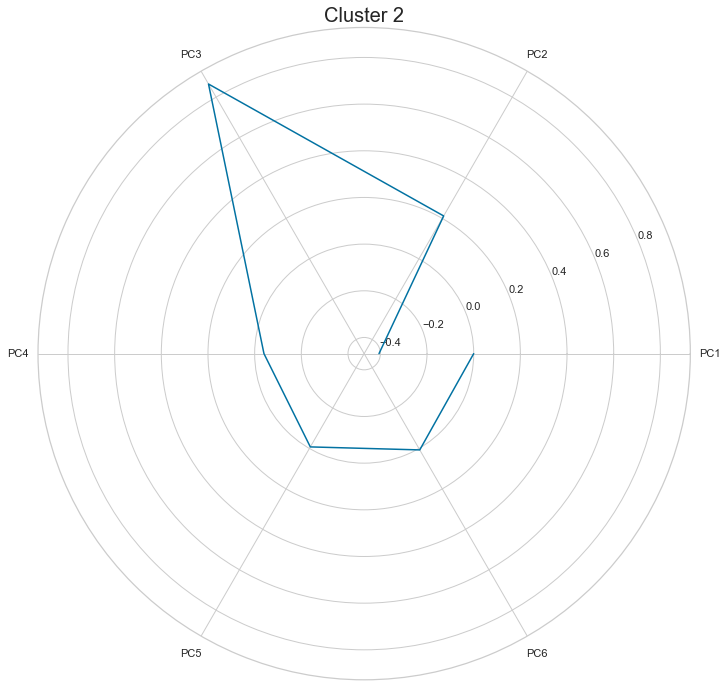

In [59]:
spider_plot(df_pca, 2)

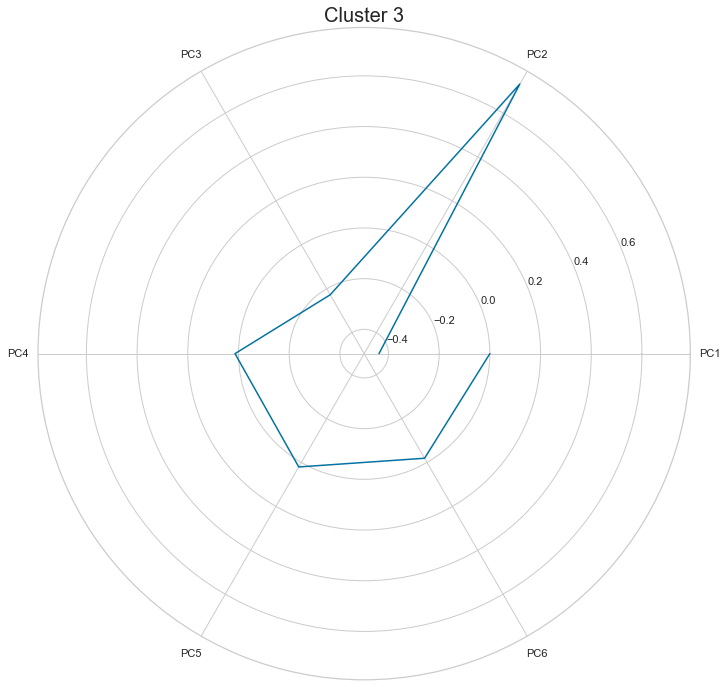

In [60]:
spider_plot(df_pca, 3)

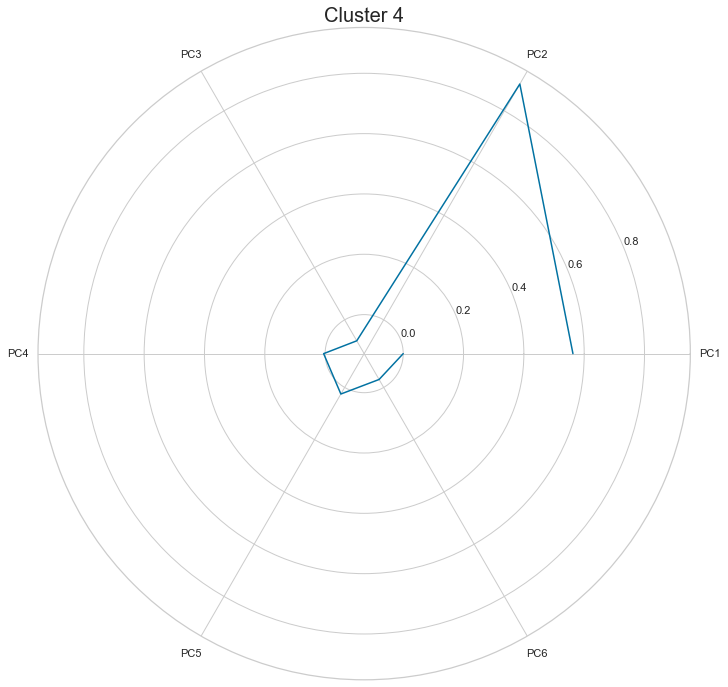

In [61]:
spider_plot(df_pca, 4)

In [62]:
df_final = df[['margemBrutaAcumulada', 'percentualRisco', 'restricoes', 'empresa_MeEppMei', 'scorePontualidade', 'endividamento', 'estoque', 'faturamentoBruto', 'custos', 'kmeans']]

In [63]:
df_final.to_csv('dados_classificados.csv', index=False)